# Decomposition Using mCG-5Kb Bins

## Content


## Input
- MCDS file
- Cell metadata

## Output
- Cell-by-5kb-bin AnnData (sparse matrix) with embedding coordinates and cluster labels.

## Import

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *
from ALLCools.mcds import MCDS

## Parameters

In [8]:
metadata_path = 'CellMetadata.PassQC.csv.gz'
mcds_path = '../../../data/PIT/RufZamojski2021NC.mcds/'

# PC cutoff
pc_cutoff = 0.1

resolution = 1

## Load Cell Metadata

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 2756 cells


CellInputReadPairs  MappingRate  FinalmCReads  \
index                                                                   
PIT_P1-PIT_P2-A1-AD001           1858622.0     0.685139     1612023.0   
PIT_P1-PIT_P2-A1-AD004           1599190.0     0.686342     1367004.0   
PIT_P1-PIT_P2-A1-AD006           1932242.0     0.669654     1580990.0   
PIT_P1-PIT_P2-A1-AD007           1588505.0     0.664612     1292770.0   
PIT_P1-PIT_P2-A1-AD010           1738409.0     0.703835     1539676.0   

                        mCCCFrac   mCGFrac   mCHFrac   Plate  Col384  Row384  \
index                                                                          
PIT_P1-PIT_P2-A1-AD001  0.003644  0.679811  0.005782  PIT_P1       0       0   
PIT_P1-PIT_P2-A1-AD004  0.004046  0.746012  0.008154  PIT_P1       1       0   
PIT_P1-PIT_P2-A1-AD006  0.003958  0.683584  0.005689  PIT_P1       1       1   
PIT_P1-PIT_P2-A1-AD007  0.003622  0.735217  0.005460  PIT_P2       0       0   
PIT_P1-PIT_P2-A1-AD010  0.003769  0.744640  0.006679  PIT_P2       1       0   

                        CellTypeAnno  
index                                 
PIT_P1-PIT_P2-A1-AD001       Outlier  
PIT_P1-PIT_P2-A1-AD004  Gonadotropes  
PIT_P1-PIT_P2-A1-AD006  Somatotropes  
PIT_P1-PIT_P2-A1-AD007        Rbpms+  
PIT_P1-PIT_P2-A1-AD010        Rbpms+

## Load MCAD

In [9]:
mcds = MCDS.open(mcds_path, var_dim='chrom5k')
mcds.add_cell_metadata(metadata)

In [12]:
mcds = mcds.remove_black_list_region(black_list_path='../../../data/genome/mm10-blacklist.v2.bed.gz')

49908 chrom5k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [13]:
mcad = mcds.get_score_adata(mc_type='CGN', quant_type='hypo-score')
mcad

AnnData object with n_obs × n_vars = 2756 × 495206
    obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno'
    var: 'chrom', 'end', 'start'

## Binarize

In [14]:
binarize_matrix(mcad, cutoff=0.95)

## Filter Features

In [15]:
filter_regions(mcad)

Filter out 206777 regions with # of non-zero cells <= 13


array([False, False, False, ...,  True,  True,  True])

In [16]:
mcad

AnnData object with n_obs × n_vars = 2756 × 288429
    obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno'
    var: 'chrom', 'end', 'start'

## LSI Decomposition

### Run LSI

In [17]:
# by default we save the results in adata.obsm['X_pca'] which is the scanpy defaults in many following functions
# But this matrix is not calculated by PCA
lsi(mcad, algorithm='arpack', obsm='X_pca')

# choose significant components
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=True)

13 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (2756, 100) to (2756, 13)


### Plot

Red axis labels are used PCs


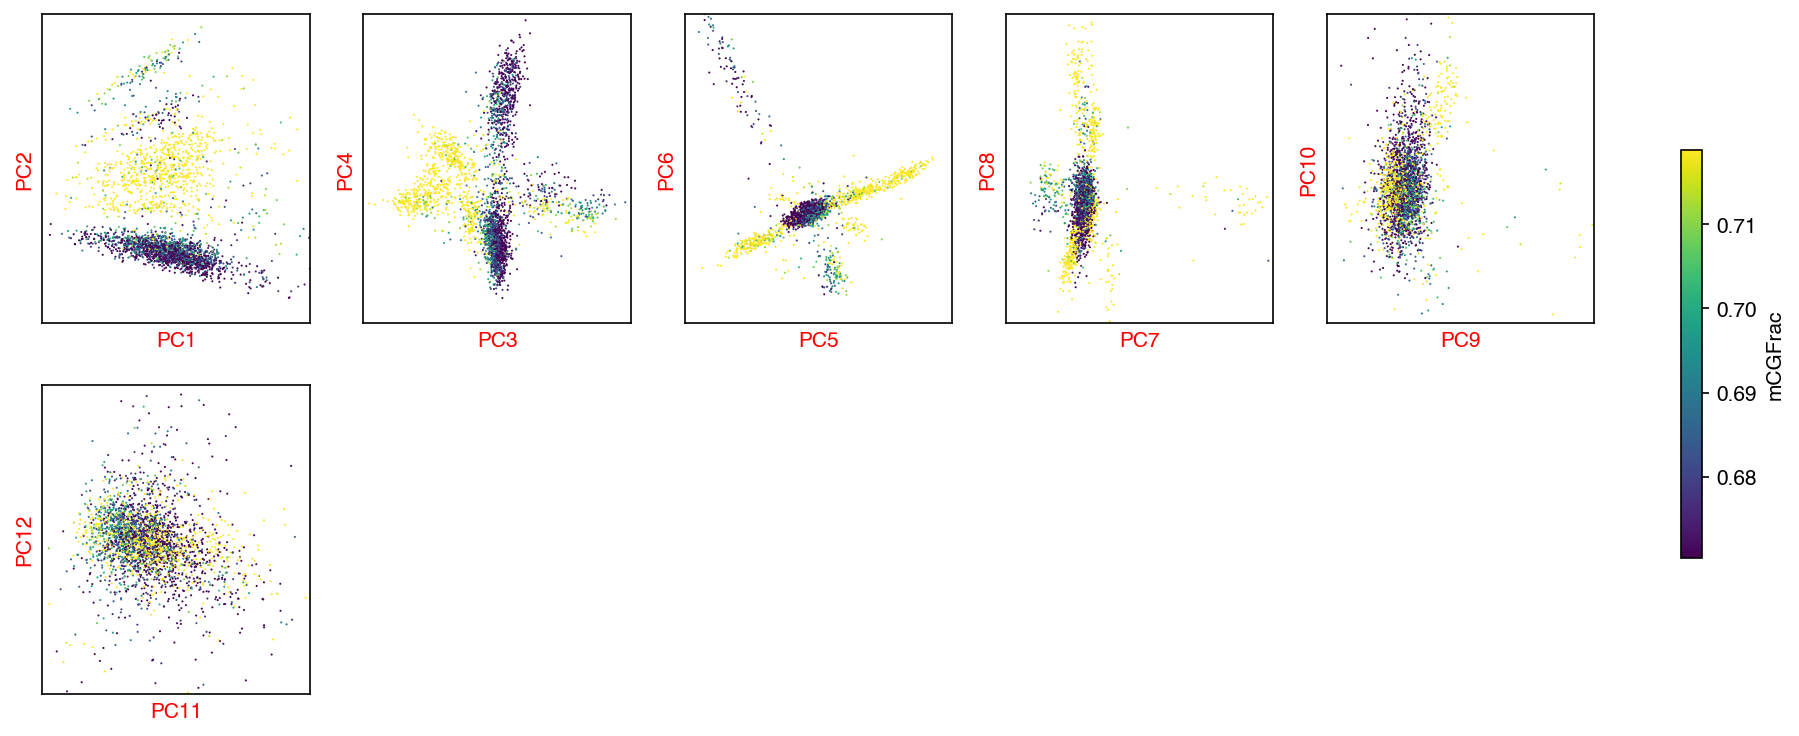

In [18]:
hue = 'mCGFrac'
if hue in metadata.columns:
    mcad.obs[hue] = metadata[hue].reindex(mcad.obs_names)
    fig, axes = plot_decomp_scatters(mcad,
                                     n_components=n_components,
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=5,
                                     ncols=5)

## Basic Clustering

In [19]:
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

## Manifold learning

### tSNE

In [20]:
tsne(mcad,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

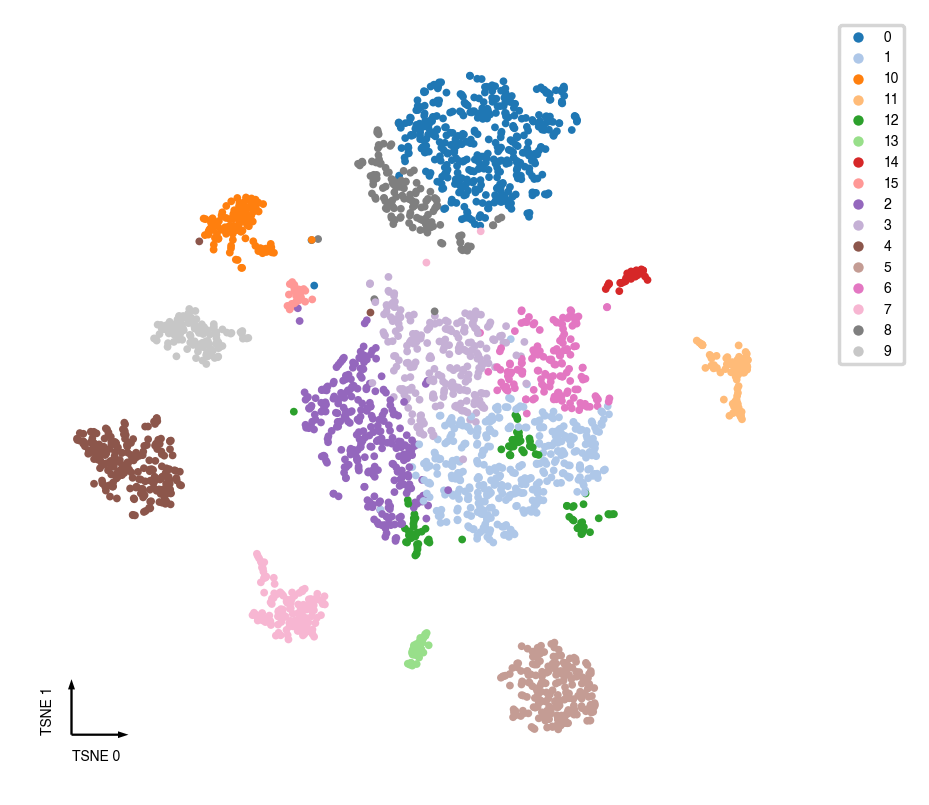

In [21]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=mcad, ax=ax, coord_base='tsne', hue='leiden', show_legend=True)

### UMAP

In [22]:
try:
    sc.tl.paga(mcad, groups='leiden')
    sc.pl.paga(mcad, plot=False)
    sc.tl.umap(mcad, init_pos='paga')
except:
    sc.tl.umap(mcad)

/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Plate' as categorical
/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellTypeAnno' as categorical
/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecate

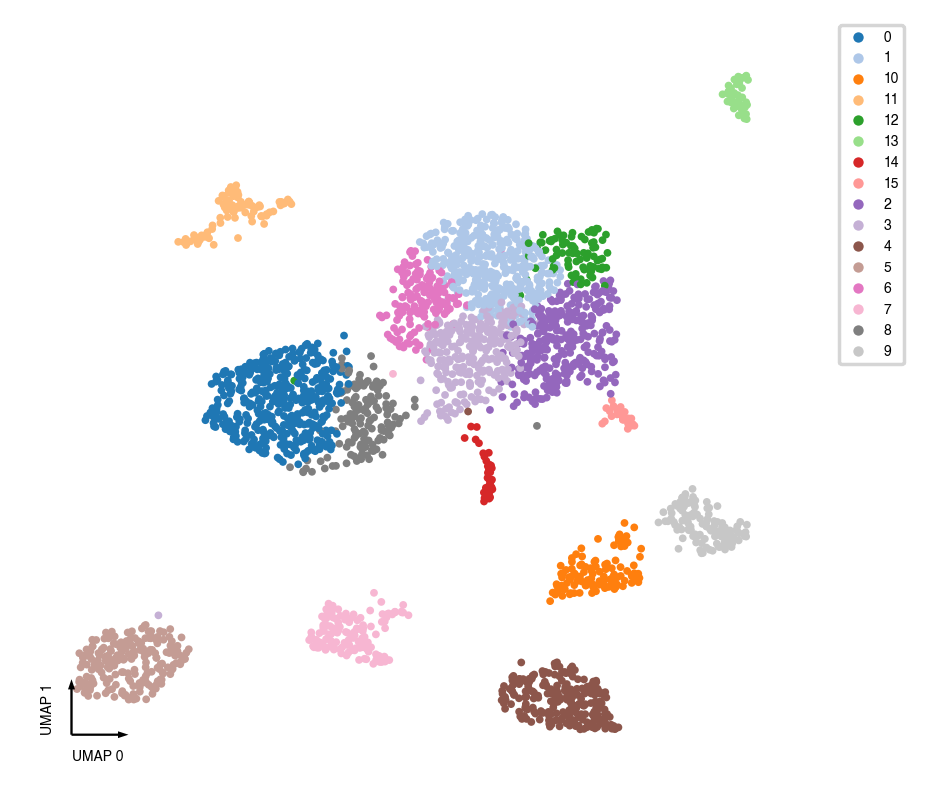

In [23]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=mcad, ax=ax, coord_base='umap', hue='leiden', show_legend=True)

### Interactive Scatter

In [26]:
interactive_scatter(data=mcad, hue='leiden', coord_base='umap')

## Save results

In [27]:
mcad.write_h5ad(f'adata.with_coords.mcad')
mcad

AnnData object with n_obs × n_vars = 2756 × 288429
    obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno', 'leiden'
    var: 'chrom', 'end', 'start'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'